In [1]:
import threading
import time
class htmlSpider(threading.Thread):
    def __init__(self, url, sem):
        super().__init__()
        self.url = url
        self.sem = sem

    def run(self):
        time.sleep(2)
        print("got html text success")
        self.sem.release() # 内部维护的计数器加1，并通知内部维护的conditon通知acquire

class UrlProducer(threading.Thread):
    def __init__(self, sem):
        super().__init__()
        self.sem = sem

    def run(self):
        for i in range(20):
            self.sem.acquire() # 内部维护的计数器减1，到0就会阻塞
            html_thread = htmlSpider("http://baidu.com/{}".format(i), self.sem)
            html_thread.start()

if __name__ == "__main__":
    sem = threading.Semaphore(3) #设置同时最多3个
    url_producer = UrlProducer(sem)
    url_producer.start()

In [2]:
sem = threading.Semaphore(3) #设置同时最多3个
url_producer = UrlProducer(sem)
url_producer.start()

In [3]:
import time
import threading

def foo():
    time.sleep(2)   #程序休息2秒
    print("ok",time.ctime())

for i in range(20):
    t1=threading.Thread(target=foo,args=()) #实例化一个线程
    t1.start()  #启动线程

### 生产者 消费者

- 生产者和消费者共享一个初始值未空的，大小未n的缓冲区
- 缓冲区没满时，生产者才能放数据
- 缓冲区不空时，消费者才能取数据
- 缓冲区临界资源，互斥访问

`p v` 操作  同步 互斥  资源申请 释放

分析方法：  
1 关系分析  几种进程，他们之间的关系  
2 确定大致的PV操作  
3 设置信号量  互斥信号量一般为1，同步信号量题意初始状态n

- 生产者和消费者共享一个初始值未空的，大小未n的缓冲区 `产品` `缓冲区`
- 缓冲区没满时，生产者才能放数据 `同步`
- 缓冲区不空时，消费者才能取数据 `同步`
- 缓冲区临界资源，互斥访问     `互斥` `临界资源是否满`  

三个信号量：`产品` `缓冲区` `临界资源`  
生产者：每次消耗(`P`)一个空闲缓冲区，并生产(`V`)一个产品  
消费者：每次消耗(`P`)一个产品，并释放(`V`)一个空闲缓冲区  

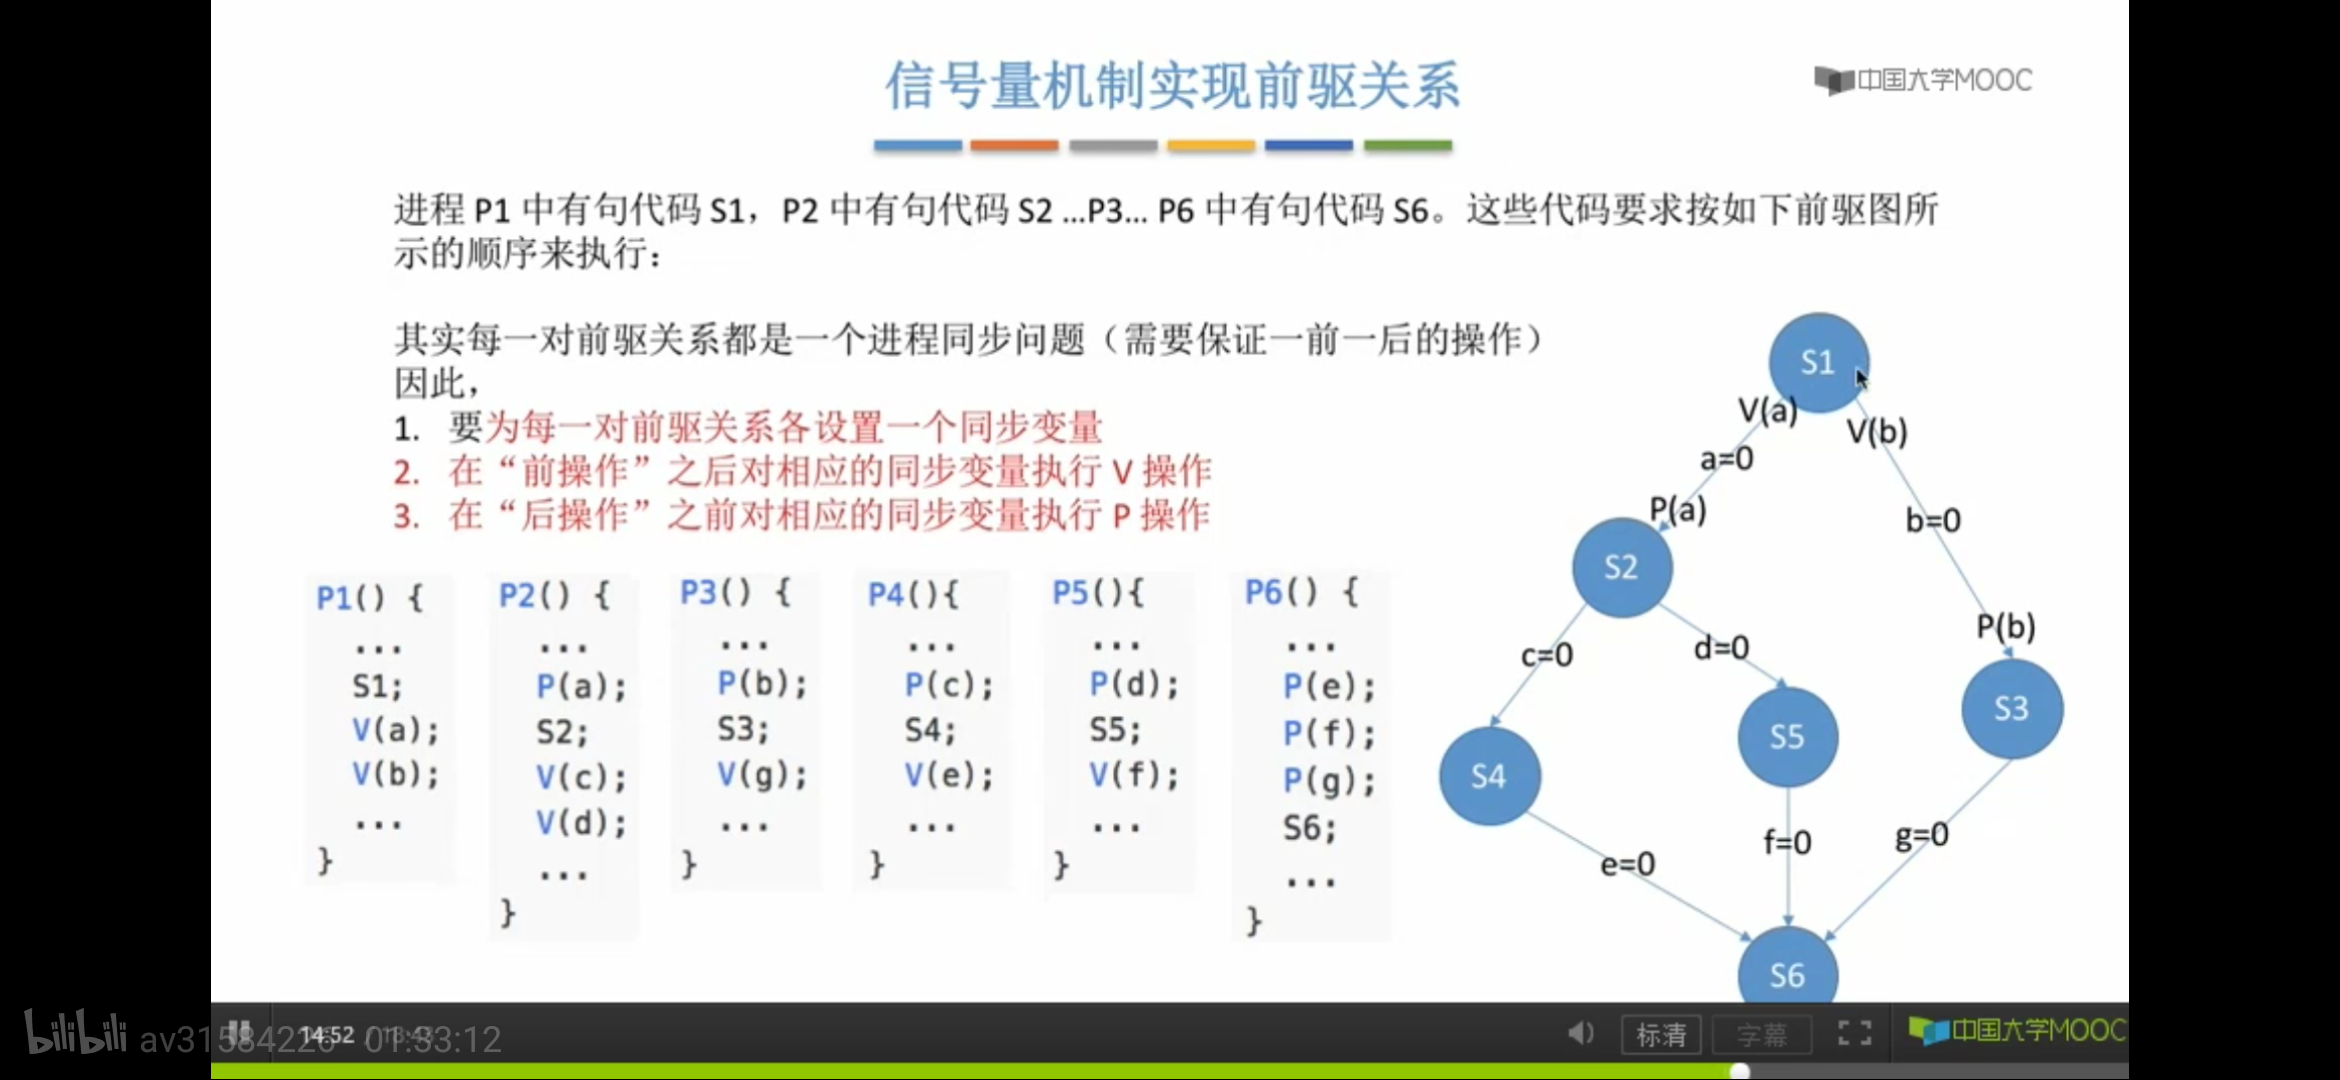

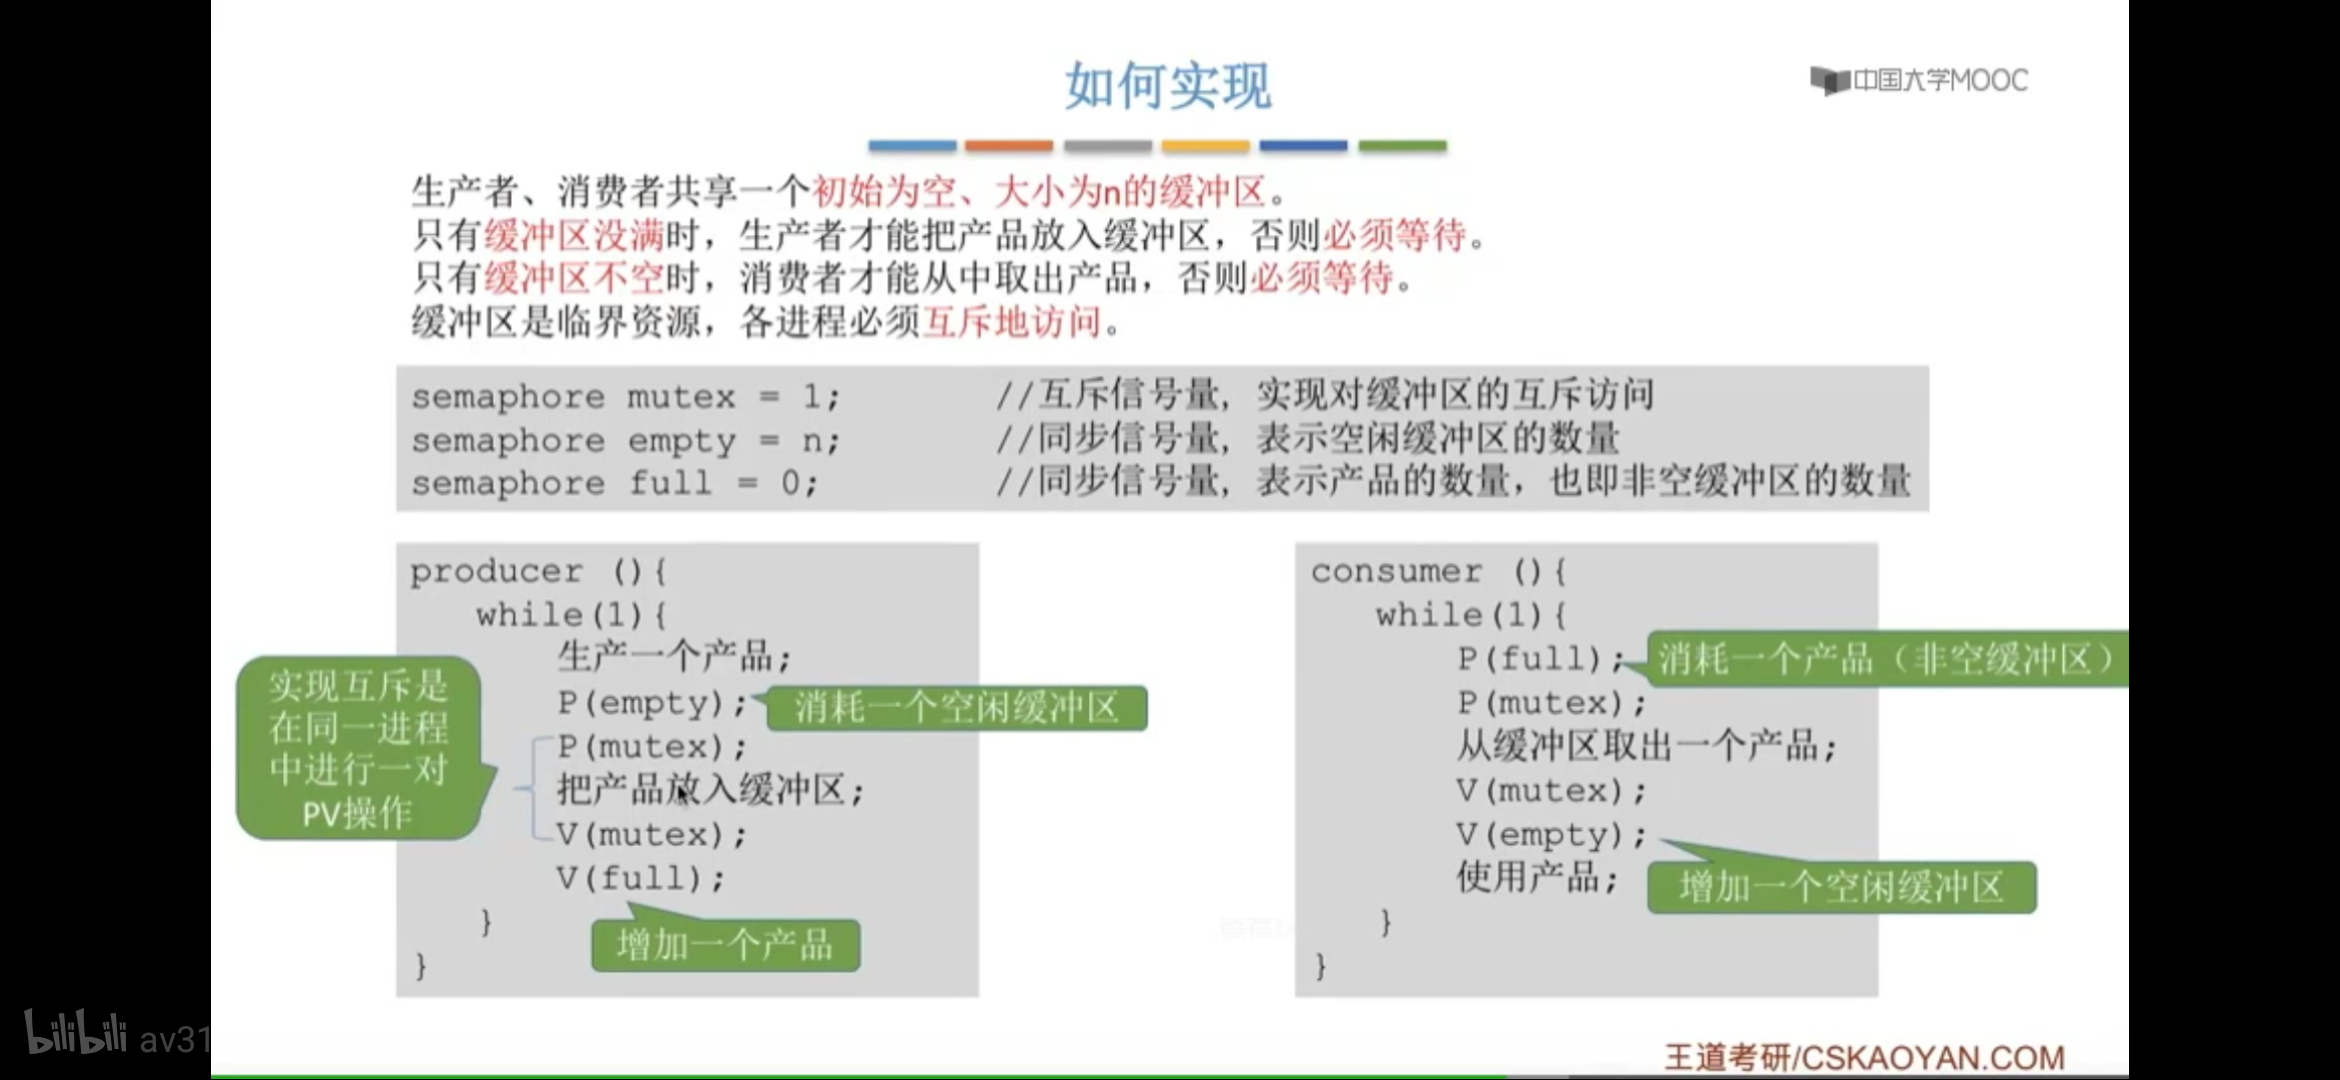

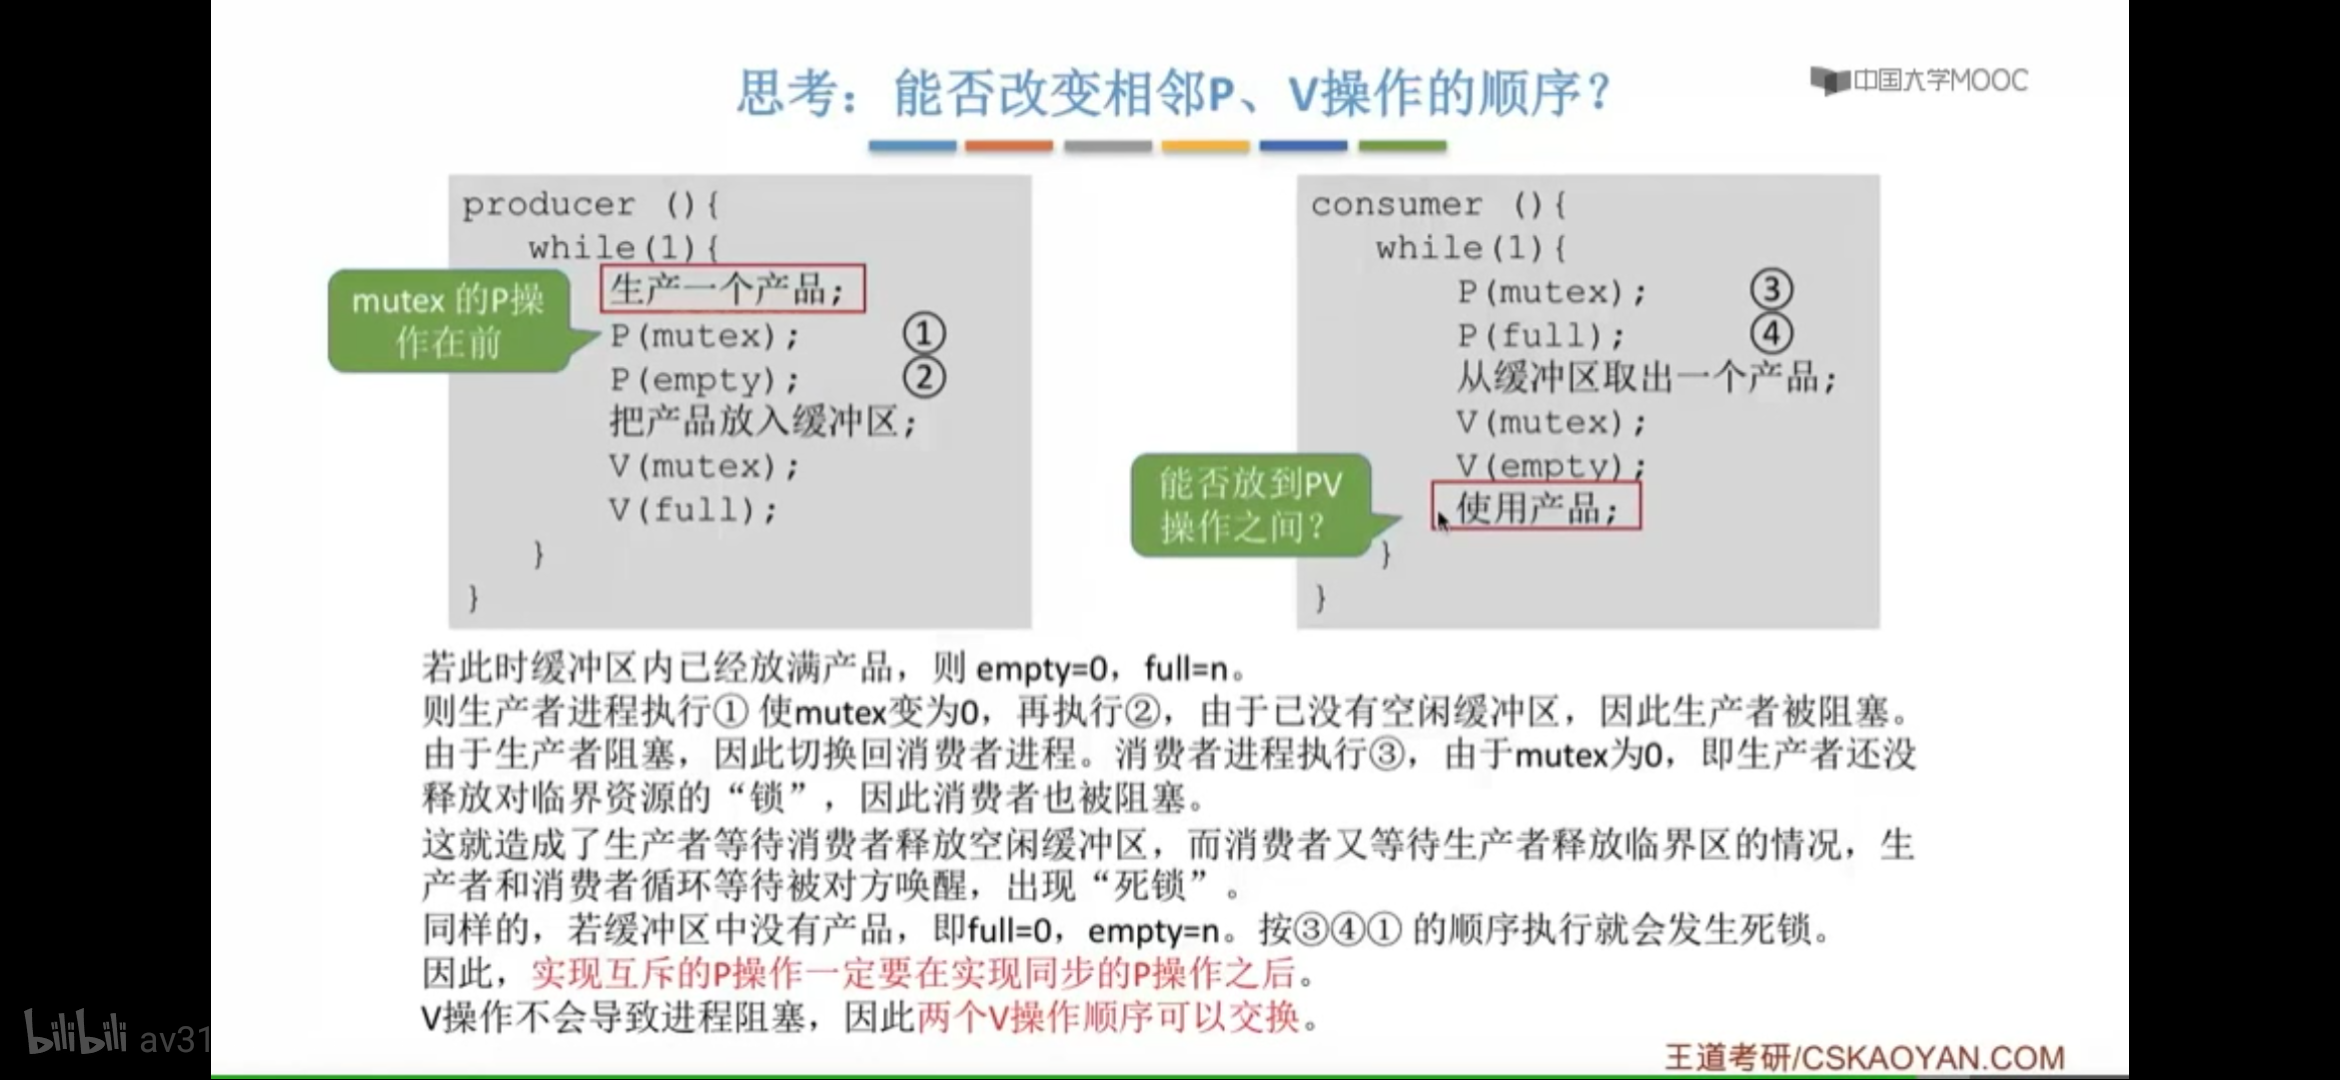

生产者 消费者  
首先有三个信号量：`是否进入临界区` `空的数量` `是否满`  
由于产品没有什么互斥，所以产品没关系，但是`空满`还是有关系的  
所以前面代码
```c
#definde N 100
typedef ... semaphore;
semaphore mutex = 1;
semaphore empty = n;
semaphore full = 0;
```
而后面又生产者，也有消费者的代码。  
对于生产者来言，生产者具有生产商品和加入缓冲区两个动作。其中进入缓冲区要求有一对互斥操作(`P,V`)，而~~加入缓冲区之前需要检验是否为满，(`P(full)`)，加入后需要减少空的数量(`V(empty)`)~~ 加入缓冲区之前需要先减少缓冲区空闲的数量(`P(empty)`)，加入后需要增加`full`的数量(`V(full)`).消费者则要在取走产品之前，先消耗一个`full`，也就是执行`P(full)`操作，然后进入缓冲区，检查是否为空(`P(empty)`)

其实同步也不难，前操作和后操作明白了之后就简单了，要在前操作加`V`,在后操作用`P`
```c
producer(){
    while(1){
        生产一个产品;
        P(empty);
        P(mutex);
        把产品放入缓冲区；
        V(mutex);
        V(full);
    }
}
```

生产者先加入再说，消耗一个`empty`，然后是缓冲区的事情，最后成功了之后，释放一个满`full`  
消费者先取走一个再说，故消耗一个`full`，然后是缓冲区事情，最后成功了之后，释放一个空`empty`  
然而缓冲区不太一样，缓冲区是一个互斥的单元，故需要一对`PV`操作。

```c
cosumer(){
    while(1){
        P(full);
        P(mutex);
        取走一个商品;
        V(mutex);
        V(empty);
        消耗商品;
    }
}

```

```c++
#definde N 100
typedef struct semaphore;
semaphore mutex=1;//互斥量一般等于1
semaphore empty = N;//同步量等于初始值
semaphore full = 0;//初始值一般题目会给
//只是有时候不是特别好想
produce(){
    while(1){
        生产一个产品;
        P(empty);
        P(mutex);
        加入缓冲区放入产品;
        V(mutex);
        V(full);
    }
}
// 生产者说：我先把空的干一个，然后看能不能放进去，放进去的话，那么满就会多一个了
customer(){
    while(1){
        P(full);
        P(mutex);
        从缓冲区取走一个产品;
        V(mutex);
        V(empty);
        消耗该产品;
    }
}
// 消费者说：我也一样，我先把满干掉一个，能取走的话，那么空也就多了一个了
```

**信号量如何实现同步？**  
设置同步信号初始值`S=0`  
在`前操作`之后执行`V(S)`  
在`后操作`之前执行`P(S)`  
原因：对于`P(S)`来言，在`S=0`时是无法执行的，程序会挂起，只有在`V(S)`后才会执行。  
四个字：
> 前V后P

### 更多的多线程问题

最重要的是发现同步和互斥关系  
刚刚的生产者和消费者问题中，就有满了情况下生产者等待消费者消费  
消费者在empty情况下等待生产者生产

#### 多消费者多生产者问题

不同类别的生产者和不同类别的消费者

大小为1，初始值为0的缓冲区，有两个生产者进程和两个消费者进程   

可以生产多个产品的单生产者问题  

#### 读者 写者

In [4]:
import threading, time, queue
q = queue.Queue()
def Produce(name):
    count = 0   #   conut表示做的包子总个数
    while count < 10:
        print('厨师%s在做包子中...'%name)
        time.sleep(2)
        q.put(count) # 容器中添加包子
  # 当做完一个包子后就要给顾客发送一个信号,表示已经做完,让他们吃包子
        print('produce  %s已经做好了第%s个包子'%(name, count))
        count += 1
        print('oking...')
def Consumer(name):
    count = 0    #  count表示包子被吃的总个数
    while count < 10:
        time.sleep(2)  #  排队去取包子,
        if not q.empty():   # 如果存在
            data = q.get() #  取包子, 吃包子
            print('\033[32;1mConsumer %s已经把第%s个包子吃了...\033[0m' %(name, data))
        else:
            print('包子被吃完了...\n')
        count += 1
if __name__ == '__main__':
    p1 = threading.Thread(target=Produce, args=('A君',))
    c1 = threading.Thread(target=Consumer, args=('B君',))
    c2 = threading.Thread(target=Consumer, args=('C君',))
    c3 = threading.Thread(target=Consumer, args=('D君',))
    p1.start()
    c1.start()
    c2.start()
    c3.start()

厨师A君在做包子中...


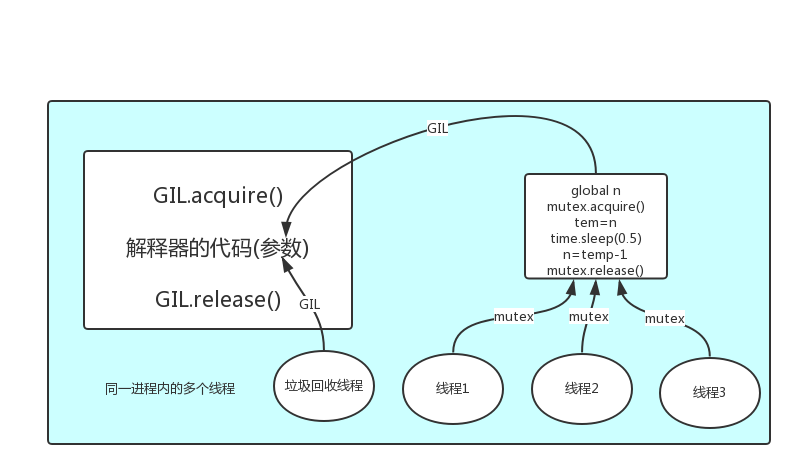

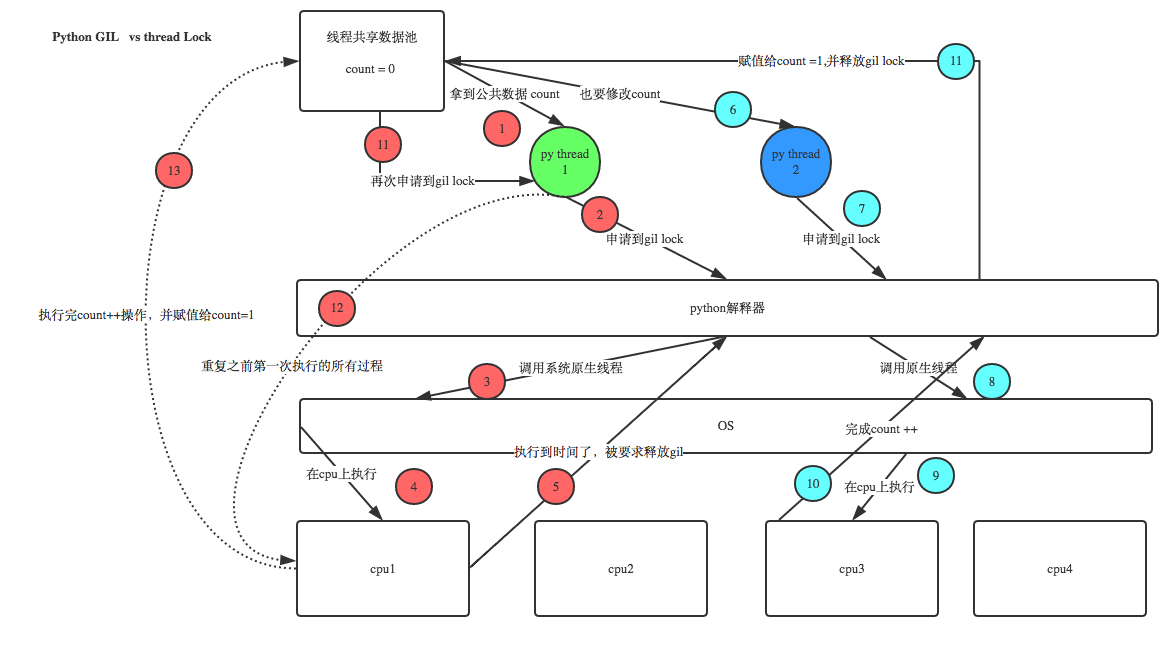

### 传参数

In [118]:
import threading
import time
import random
def say_hello(count, name):
    time.sleep(random.randint(1,3))
    print("Hello world!", name)
    count -= 1

def main():
    name_list = ['Bob', 'Jack', 'Jone', 'Mike', 'David']
    for i in range(5):
        thread = threading.Thread(target=say_hello, args=(10, name_list[i]))
        thread.start()

main()

在`threading.Thread`类中，常用的方法有：

- `isAlive`: 检查线程是否在运行中
- `getName`: 获取线程名称
- `setName`: 设置线程名称
- `join`：阻塞线程调用，直到线程中止
- `setDaemon`：设置线程为守护线程
- `isDaemon`: 判断线程是否是守护线程

#### 通过继承创建线程

In [119]:
import threading

class MyThread(threading.Thread):
      def __init__(self, count, name):
          super(MyThread, self).__init__()
          self.count = count
          self.name = name
     
      def run(self):
          while self.count > 10:
                print("hello", self.name) 
                self.count -= 1

### Random类

In [117]:
# # random.sample(list(range(0,9)),4)
# a = list(range(0,9))
# random.shuffle(a)
# a
# random.uniform(1,2)
# random.randint(1,1)
# random.randrange(start=1,stop=5,step=1)
# random.choices(range(0,9),k=2)
# random.choice(range(0,9))
# random.BPF?